### 1. Business Understanding

The dataset we will analyze here, consists of information about domestic flights operated by large airlines in the U.S. throughout 2008. It provides details about the schedule and delays of each flight. The data was originally  compiled and made available to the public by the Bureau of Transportation Statistics, but for our purposes we will use the version available at Kaggle: 

[https://www.kaggle.com/giovamata/airlinedelaycauses](https://www.kaggle.com/giovamata/airlinedelaycauses)

Each record comprises details about a specific flight, such as its number, origin, destination, airline, scheduled timeline and actual timeline. Information about delays (deviations from the scheduled timeline) is particularly intersting, as it provides us with the opportunity to analyze how delays are related to other factors and how much are domestic flights affected. The results will hopefully provide insights useful to passengers.

In view of the information at hand, we could consider digging for answers to the following questions:

1. Which were the best and the worst carriers (airlines) regarding delays and cancellations in 2008?


2. Can we identify months of the year 2008 when delays were particularly long?


3. What were the major causes of delays affecting domestic flights in the U.S. in 2008?


4. Can we build a model to estimate how much delay could be expected in a flight?


The answers we arrive at will hopefully help passengers make more informed decisions in their travels and avoid the inconveniences of getting into a delayed flight. 

### 2. Data Understanding

By invoking the info function on the DataFrame, we see that it contains 1936758 records and 30 variables:

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVR
from sklearn.metrics import r2_score
import Utilities as util
%matplotlib inline

df_flight_delays = pd.read_csv("datasets/DelayedFlights.csv")

print(f"Airline Delays. Records: {df_flight_delays.shape[0]}, variables: {df_flight_delays.shape[1]}")

# Get the size of the dataset, list of the variables with their types
df_flight_delays.info()

Airline Delays. Records: 1936758, variables: 30
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1936758 entries, 0 to 1936757
Data columns (total 30 columns):
Unnamed: 0           int64
Year                 int64
Month                int64
DayofMonth           int64
DayOfWeek            int64
DepTime              float64
CRSDepTime           int64
ArrTime              float64
CRSArrTime           int64
UniqueCarrier        object
FlightNum            int64
TailNum              object
ActualElapsedTime    float64
CRSElapsedTime       float64
AirTime              float64
ArrDelay             float64
DepDelay             float64
Origin               object
Dest                 object
Distance             int64
TaxiIn               float64
TaxiOut              float64
Cancelled            int64
CancellationCode     object
Diverted             int64
CarrierDelay         float64
WeatherDelay         float64
NASDelay             float64
SecurityDelay        float64
LateAircraftDelay    floa

The following table provides a description and the type of each variable:

Number | Name | Description | Type
:------: | :---- | :---- | :----
1 | (Unamed) | Sequential record number | Numerical, integer
2 | Year | 2008 | Numerical, integer
3 | Month | Month number (1=January - 12=December) | Numerical, integer
4 | DayofMonth | Day number of the month (1 - 31) | Numerical, integer
5 | DayOfWeek | Day number of the week (1=Monday - 7=Sunday) | Numerical, integer
6 | DepTime | Actual departure time (local, hhmm) | Numerical, integer
7 | CRSDepTime | Scheduled departure time (local, hhmm) | Numerical, integer
8 | ArrTime | Actual arrival time (local, hhmm) | Numerical, integer
9 | CRSArrTime | Scheduled arrival time (local, hhmm) | Numerical, integer
10 | UniqueCarrier | Unique carrier code | Categorical, string
11 | FlightNum | Flight number | Numerical, integer
12 | TailNum | Plane tail number | Categorical, string
13 | ActualElapsedTime | Actual total flight time, in minutes | Numerical, decimal
14 | CRSElapsedTime | Total flight time estimated by the carrier, in minutes | Numerical, decimal
15 | AirTime | Time in the air, in minutes | Numerical, decimal
16 | ArrDelay | Delay to arrive at the destination airport, in minutes | Numerical, decimal
17 | DepDelay | Delay to depart from the origin airport, in minutes | Numerical, decimal
18 | Origin | Origin IATA airport code | Categorical, string
19 | Dest | Destination IATA airport code | Categorical, string
20 | Distance | Travel in miles | Numerical, integer
21 | TaxiIn | Taxi in time (time to roll from the terminal to the runway), in minutes | Numerical, decimal
22 | TaxiOut | Taxi out time (time to roll from the runway to the terminal) in minutes | Numerical, decimal
23 | Cancelled | Was the flight cancelled? | Numerical, boolean
24 | CancellationCode | Reason why flight was cancelled (A=carrier, B=weather, C=NAS, D=security) | Categorical, string
25 | Diverted | Was the flight diverted to another destination? (1=yes, 0=no) | Numerical, integer
26 | CarrierDelay | Delay caused by the carrier, in minutes | Numerical, decimal
27 | WeatherDelay | Delay caused by the weather, in minutes | Numerical, decimal
28 | NASDelay | Delay caused by the NAS (National Airspace System), in minutes | Numerical, decimal
29 | SecurityDelay | Delay caused by security issues, in minutes | Numerical, decimal
30 | LateAircraftDelay | Delay caused by the aircraft arriving late, in minutes | Numerical, decimal

There are five categorical variables: UniqueCarrier, TailNum, Origin, Dest and CancellationCode. The rest are all numerical. However, when performing operations on DepTime, CRSDepTime, ArrTime and CRSArrTime we must bear in mind that these represent times in hour-minute format.

In [2]:
# Get the names of all categorical variables
print(f"Categorical variables: {df_flight_delays.select_dtypes(include=['object']).columns.values}")

Categorical variables: ['UniqueCarrier' 'TailNum' 'Origin' 'Dest' 'CancellationCode']


##### 2.1 Summary statistics

We get an overview of the variables we are interested in analyzing, by computing some summary statistics:

In [3]:
# Variables we aim to draw conclusions about
target_vars = ["ArrDelay", "DepDelay", "Cancelled", "Diverted"]

# Compute summary statistics about these variables, including the 95th and 99th percentiles
df_summary_stats = df_flight_delays[target_vars].describe(percentiles=[0.25, 0.5, 0.75, 0.95, 0.99])

df_summary_stats

,ArrDelay,DepDelay,Cancelled,Diverted
count,1.928371e+06,1.936758e+06,1.936758e+06,1.936758e+06
mean,4.219988e+01,4.318518e+01,3.268348e-04,4.003598e-03
std,5.678472e+01,5.340250e+01,1.807562e-02,6.314722e-02
min,-1.090000e+02,6.000000e+00,0.000000e+00,0.000000e+00
25%,9.000000e+00,1.200000e+01,0.000000e+00,0.000000e+00
50%,2.400000e+01,2.400000e+01,0.000000e+00,0.000000e+00
75%,5.600000e+01,5.300000e+01,0.000000e+00,0.000000e+00
95%,1.480000e+02,1.430000e+02,0.000000e+00,0.000000e+00
99%,2.560000e+02,2.490000e+02,0.000000e+00,0.000000e+00
max,2.461000e+03,2.467000e+03,1.000000e+00,1.000000e+00


The fact that the 99th percentile is at least an order of magnitude lower than the maximum, for both delay variables, suggests that these contain some heavy outliers. 

We verify this by assigning a value slightly above the 99th percentile to all outliers beyond that point and then plotting the results. This has the effect of "compressing" the most extreme outliers in a single spot, which in turn prevents the plots from becoming unreadable.

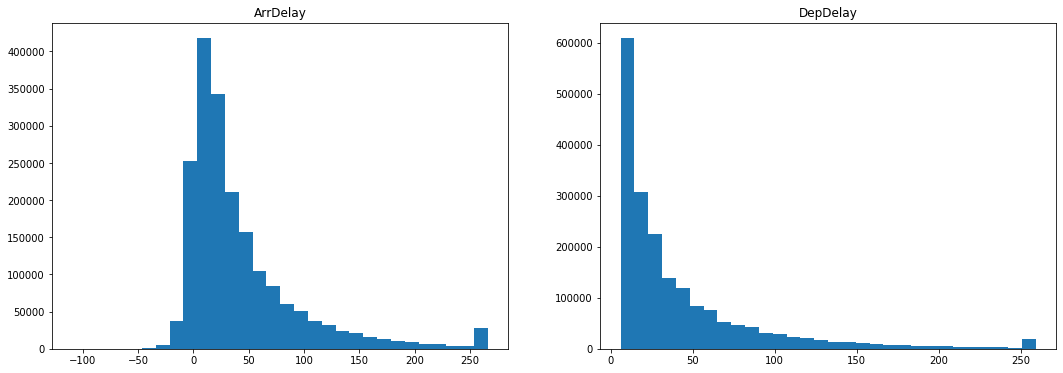

In [4]:
def plot_variable(var, fig_axis):
    """
    Adds a histogram to a figure axis of the plot, depicting the specified variable
    INPUT
        var - name of the variable to be plotted
        fig_axis - axies of the figure 
    OUTPUT
        adds histogram of variable var as a subplot
    """
    # Value of the 99th percentile
    outlier_lim = df_summary_stats[var]["99%"]
    
    # Assign a value slightly higher than the 99th percentile to all observations that surpass that limit
    compressed_outls = df_flight_delays[var].transform(lambda v: v if v <= outlier_lim else (outlier_lim + 10))
    
    fig_axis.hist(compressed_outls, bins=30)
    fig_axis.set_title(var)

# Create a figure containing two plots
fig1 = plt.figure(figsize=(18, 6))
axes = fig1.subplots(nrows=1, ncols=2)

# Plot a histogram for arrival delays and departure delays into the figure
for ix, var in enumerate(["ArrDelay", "DepDelay"]):
    plot_variable(var, axes[ix])

plt.show()

In both histograms the last bar represents the outliers greater than the 99th percentile. As we suspected, there are a very few of them. However, we have to keep in mind these extreme values when using models sensitive to outliers. We can also notice that both of our target variables are considerably right-skewed. 

The summary statistics also confirm that variables Cancelled and Diverted are boolean, even though they are stored as decimal numbers.

### 3. Data Preparation

Now we will examine the data in search for errors and inconsistencies and modify it as necessary to facilitate further analysis.

Note that the first variable (Unamed: 0) just enumerates the rows. It can be safely discarded as it doesn't  provide any useful information. We can also drop the variable Year, as all observations are of the same year (2008) in this version of the dataset.

In [5]:
# Drop the first column, which just provides enumerates the rows. The DataFrame index does so already
df_flight_delays.drop(["Unnamed: 0", "Year"], axis=1, inplace=True)

Now let's check for missing values. We start by counting how many we have in each variable:

In [6]:
# Count total and percentage of missing values in each variable of the dataset
util.build_nan_data(df_flight_delays)

,# Missing,% Missing
Month,0,0.000000
DayofMonth,0,0.000000
DayOfWeek,0,0.000000
DepTime,0,0.000000
CRSDepTime,0,0.000000
ArrTime,7110,0.367108
CRSArrTime,0,0.000000
UniqueCarrier,0,0.000000
FlightNum,0,0.000000
TailNum,5,0.000258


Since several of our questions are concerned with the schedule of flights, the variables ArrTime, ActualElapsedTime, CRSElapsedTime, AirTime, ArrDelay, TaxiIn, TaxiOut, CarrierDelay, WeatherDelay, NASDelay, SecurityDelay and LateAircraftDelay are particularly important. Hence, we should examine the missing values they contain and handle them the best we can.

##### 3.1 Flights with missing ArrTime

Taking a look at some of the flights that have missing ArrTime values, it appears that all of them are either cancelled or diverted.

In [7]:
# Get flights that have ArrTime missing and print the first 5
df_missing_arrtime = df_flight_delays[df_flight_delays["ArrTime"].isna()]
df_missing_arrtime[["Cancelled", "Diverted"]].head(10)

,Cancelled,Diverted
1280,0,1
1372,0,1
1776,0,1
1831,0,1
2244,0,1
2245,0,1
2720,0,1
2831,0,1
3075,0,1
3179,0,1


We can verify if that's really the case by counting how many of such flights are actually cancelled or diverted.

In [8]:
# Count how many of the flights missing ArrTime were also cancelled or diverted
total_missing_arrtime_diverted_or_cancelled = sum((df_missing_arrtime["Cancelled"] == 1.0) | 
                                                  (df_missing_arrtime["Diverted"] == 1.0))

print(f"Total missing ArrTime: {df_missing_arrtime.shape[0]}. Cancelled/Diverted: {total_missing_arrtime_diverted_or_cancelled}")

Total missing ArrTime: 7110. Cancelled/Diverted: 7110


This means that the dataset does not provide arrival times for flights that were cancelled or diverted, which intuitively makes sense.

##### 3.2 Flights with missing ActualElapsedTime, AirTime and ArrDelay

Interestingly, these three variables have the same number of missing values. This suggests that if a flight is missing the value of any of them, it's actually missing the values of all three. We can easily verify this by comparing how many rows have all vs. any of these variables missing.

In [9]:
# Get rows with missing values in any of the variables ActualElapsedTime, AirTime or ArrDelay
df_missing_any_3 = df_flight_delays[(df_flight_delays["ActualElapsedTime"].isna()) |
                                  (df_flight_delays["AirTime"].isna()) |
                                  (df_flight_delays["ArrDelay"].isna()) | df_flight_delays["AirTime"].isna()]

# Get rows with missing values in all of the variables ActualElapsedTime, AirTime and ArrDelay
df_missing_all_3 = df_flight_delays[(df_flight_delays["ActualElapsedTime"].isna()) &
                                  (df_flight_delays["AirTime"].isna()) &
                                  (df_flight_delays["ArrDelay"].isna()) & df_flight_delays["AirTime"].isna()]

print(f"Total missing all ActualElapsedTime, AirTime and ArrDelay: {df_missing_all_3.shape[0]}. Total missing any: {df_missing_any_3.shape[0]}")

Total missing all ActualElapsedTime, AirTime and ArrDelay: 8387. Total missing any: 8387


Moreover, by inspecting the rows we see that apparently, all these flights were either cancelled or diverted too. We verify this hunch by counting how many of the flights missing ActualElapsedTime, AirTime and ArrDelay were actually cancelled or diverted. 

In [10]:
# Count all flights missing the 3 variables and how many among them were either cancelled or diverted
total_missing_3 = df_missing_any_3.shape[0]
total_missing_3_cld_dvrt = sum((df_missing_any_3["Cancelled"] == 1.0) | (df_missing_any_3["Diverted"] == 1.0))

# If these counts are equal, then all flights missing the 3 variables were either cancelled or diverted
were_all_missing_3_cld_dvrt = (total_missing_3 == total_missing_3_cld_dvrt)

print(f"Were all flights missing ActualElapsedTime, AirTime and ArrDelay cancelled or diverted? {were_all_missing_3_cld_dvrt}")

# Count how many flights in total were either cancelled or diverted
total_cld_dvrt = sum((df_flight_delays["Cancelled"] == 1.0) | (df_flight_delays["Diverted"] == 1.0))

print(f"Total flights cancelled or diverted: {total_cld_dvrt}")

Were all flights missing ActualElapsedTime, AirTime and ArrDelay cancelled or diverted? True
Total flights cancelled or diverted: 8387


From 3.1 and 3.2, we conclude that all flights that failed to bring passengers to their intended destination (i.e. flights that were either cancelled or diverted), have missing values for ActualElapsedTime, AirTime and ArrDelay. Furthermore, most of these flights (7110 out of 8387) have missing values for ArrTime. 

On the one hand, these variables are crucial for analyzing delays and durations of successful flights. On the other hand they are not useful in the analysis of failed flights. Therefore, it makes sense to split the dataset in two groups:

- _Successful flights:_ not cancelled nor diverted. Brought passengers to the intended destination. Have complete  information about delays.
- _Failed flights:_ cancelled or diverted. Failed to bring passengers to the intended destination. Have no information about delays.

In this way, we get a dataset with no values missing for these important variables. Analyzing this dataset of successful flights separately from the dataset of failed flights is easier and less prone to errors.

In [11]:
# Split dataset in successful and failed flights 
df_success_flights = df_flight_delays[(df_flight_delays["Cancelled"] == 0.0) & (df_flight_delays["Diverted"] == 0.0)].copy()
df_failed_flights = df_flight_delays[(df_flight_delays["Cancelled"] == 1.0) | (df_flight_delays["Diverted"] == 1.0)].copy()

print(f"Total flights: {df_flight_delays.shape[0]}. Successful: {df_success_flights.shape[0]}. Failed: {df_failed_flights.shape[0]}")

Total flights: 1936758. Successful: 1928371. Failed: 8387


##### 3.3 Missing values in successful flights

Let's now take a look at the missing values that remain in the dataset of successful flights.

In [12]:
# Count total and percentage of values missing in variables of the successful flights dataset
util.build_nan_data(df_success_flights)

,# Missing,% Missing
Month,0,0.000000
DayofMonth,0,0.000000
DayOfWeek,0,0.000000
DepTime,0,0.000000
CRSDepTime,0,0.000000
ArrTime,0,0.000000
CRSArrTime,0,0.000000
UniqueCarrier,0,0.000000
FlightNum,0,0.000000
TailNum,3,0.000156


There are just three rows with missing TailNum values. This is an insignificant number of rows relative to the size of the dataset, so we can just drop them.

In [13]:
# Drop rows having missing values for the TailNum variable
df_success_flights.dropna(subset=["TailNum"], inplace=True)

Alas, there are quite a lot of missing values in the categorized delay variables. Each of these variables, ArrDelay, CarrierDelay, WeatherDelay, NASDelay, SecurityDelay and LateAircraftDelay has 35.31% of their values missing. These variables provide information about the potential causes for a flight to be delayed and thus, may be very useful in our analysis. For this reason, we impute missing values in these variables as follows:

- Firstly, we get all the flights having values for all the delay category variables.  

In [14]:
# In this part, we care only about delay-related variables
df_all_delay_data = df_success_flights[["ArrDelay", "CarrierDelay", "WeatherDelay", "NASDelay",
                                        "SecurityDelay", "LateAircraftDelay"]]

# Get flights that have complete information about delays
df_flights_full_dly_data = df_all_delay_data[(df_success_flights["ArrDelay"].isna() == False) &
                                             (df_success_flights["CarrierDelay"].isna() == False) &
                                             (df_success_flights["WeatherDelay"].isna() == False) &
                                             (df_success_flights["NASDelay"].isna() == False) &
                                             (df_success_flights["SecurityDelay"].isna() == False) &
                                             (df_success_flights["LateAircraftDelay"].isna() == False)]

print(f"Total flights not missing delay information: {df_flights_full_dly_data.shape[0]}")

Total flights not missing delay information: 1247486


- We use these rows to compute how each type of delay compares to the arrival delay, aggregated accross all these flights. To do so, we calculate the ratio of the aggregated delays of each type to the aggregated arrival delay. The resulting ratios can be used as weights, to split an arrival delay among the five delay types.

In [15]:
# Accumulate delays of each type and arrival delays for all flights with full delay information
df_delay_totals = df_flights_full_dly_data.sum()

# For the totals of each type of delay, compute the ratio to the total arrival delay
df_dly_weights = df_delay_totals / df_delay_totals["ArrDelay"]

- Finally, we use these weights to impute the delays of each category, based on the arrival delay. We do so for flights missing values for the delay category variables.

In [16]:
# Impute missing values for each delay category variable, by splitting up the arrival delay as to the weights
for var in ["CarrierDelay", "WeatherDelay", "NASDelay", "SecurityDelay", "LateAircraftDelay"]:
    df_success_flights[var].fillna(df_success_flights["ArrDelay"] * df_dly_weights[var], inplace=True)

# Check that there are no missing values left
util.build_nan_data(df_success_flights)

,# Missing,% Missing
Month,0,0.0
DayofMonth,0,0.0
DayOfWeek,0,0.0
DepTime,0,0.0
CRSDepTime,0,0.0
ArrTime,0,0.0
CRSArrTime,0,0.0
UniqueCarrier,0,0.0
FlightNum,0,0.0
TailNum,0,0.0


We have cleared all missing values from the dataset of successful flights!

##### 3.4 Missing values in failed flights

Regarding failed flights, we can simply drop all columns related to duration and performance, as these make sense only for flights that took off and arrived at their destination. 

There are also some missing values in variables that could turn out to be useful for analyzing failed flights: TailNum and CRSElapsedTime. Since only 0.02% and 2.36% of the failed flights have missing values for these two variables, we can just drop those rows. 

In [17]:
# Check for missing values in the dataset of failed flights
util.build_nan_data(df_failed_flights)

,# Missing,% Missing
Month,0,0.000000
DayofMonth,0,0.000000
DayOfWeek,0,0.000000
DepTime,0,0.000000
CRSDepTime,0,0.000000
ArrTime,7110,84.774055
CRSArrTime,0,0.000000
UniqueCarrier,0,0.000000
FlightNum,0,0.000000
TailNum,2,0.023846


In [18]:
try:
    # Drop columns missing values 
    df_failed_flights.drop(columns=["ArrTime", "ActualElapsedTime", "AirTime", "ArrDelay", "TaxiIn", 
                                    "TaxiOut", "CarrierDelay", "WeatherDelay", "NASDelay", 
                                    "SecurityDelay", "LateAircraftDelay"], inplace=True)
except KeyError:
    # Alright, columns were already dropped
    pass

# Drop rows missing TailNum or CRSElapsedTime
df_failed_flights.dropna(subset=["TailNum", "CRSElapsedTime"], inplace=True)

# Check again for missing values in the dataset of failed flights
util.build_nan_data(df_failed_flights)

,# Missing,% Missing
Month,0,0.0
DayofMonth,0,0.0
DayOfWeek,0,0.0
DepTime,0,0.0
CRSDepTime,0,0.0
CRSArrTime,0,0.0
UniqueCarrier,0,0.0
FlightNum,0,0.0
TailNum,0,0.0
CRSElapsedTime,0,0.0


Now the dataset of failed flights is clear of missing values too!

##### 3.5 Results

In summary, as a result of the data preparation process we have two datasets cleared of missing values:

- *df_success_flights:* will be useful to analyze and model flight delays for flights that were carried out.
- *df_failed_flights:* can be used to analyze and model flights that didn't reach their intended destination because of being cancelled or diverted.

We also have the full dataset in *df_flight_delays*, which can still be of use with analysis techniques that can deal with missing values.

### 4. Analysis and Modeling

Now that we have clean information about successful and cancelled flights, we can proceed to answer our questions and attempt model flight delays. But before going further, let's compute some more interesting statistics about the dataset to learn a bit more about it.




In [19]:
# Get the flights that got delayed more than 1 hour
df_all_delayed_flights_1h = df_success_flights[df_success_flights["ArrDelay"] > 60.0]

# Get all flights that were cancelled
df_cancelled_flights = df_failed_flights[df_failed_flights["Cancelled"] == 1.0]

# Get all flights that were diverted
df_diverted_flights = df_failed_flights[df_failed_flights["Diverted"] == 1.0]

# Compute the totals of all flights, flights with delays longer than 1 hour, flights cancelled and diverted
total_successful_flights = df_success_flights.shape[0]
total_failed_flights = df_failed_flights.shape[0]
total_flights = total_successful_flights + total_failed_flights
total_delayed_1h = df_all_delayed_flights_1h.shape[0]
total_cancelled = df_cancelled_flights.shape[0]
total_diverted = df_diverted_flights.shape[0]

# Compute the percentage of each category extracted above
perc_successful = (total_successful_flights / total_flights) * 100
perc_failed = (total_failed_flights / total_flights) * 100
perc_delayed = (total_delayed_1h / total_successful_flights) * 100
perc_cancelled = (total_cancelled / total_flights) * 100
perc_diverted = (total_diverted / total_flights) * 100

print(f"Total flights recorded: {total_flights}")
print(f"Flights successful. Total: {total_successful_flights}. Percentage: {perc_successful}")
print(f"Flights failed. Total: {total_failed_flights}. Percentage: {perc_failed}")
print(f"Flights with delay > 1 hour. Total: {total_delayed_1h}. Percentage: {perc_delayed}")
print(f"Flights cancelled. Total: {total_cancelled}. Percentage: {perc_cancelled}")
print(f"Flights diverted. Total: {total_diverted}. Percentage: {perc_diverted}")

Total flights recorded: 1936555
Flights successful. Total: 1928368. Percentage: 99.5772389630039
Flights failed. Total: 8187. Percentage: 0.4227610369961091
Flights with delay > 1 hour. Total: 439174. Percentage: 22.77438746131444
Flights cancelled. Total: 633. Percentage: 0.032686910518936976
Flights diverted. Total: 7554. Percentage: 0.39007412647717205


##### 4.1 Carrier performance

Note that in the analysis of this and the next question, we use summary statistics that are not affected by missing values. We would also like to use all the information available and thus, we prefer to make use of the full dataset in answering these questions.

Our first question is concerned about how good is the service of carriers with respect to delays and cancellations:

1. Which were the best and the worst carriers (airlines) regarding delays and cancellations in 2008?

To answer this question, let's compute the average departure and arrival delay for each carrier and analyze the results.

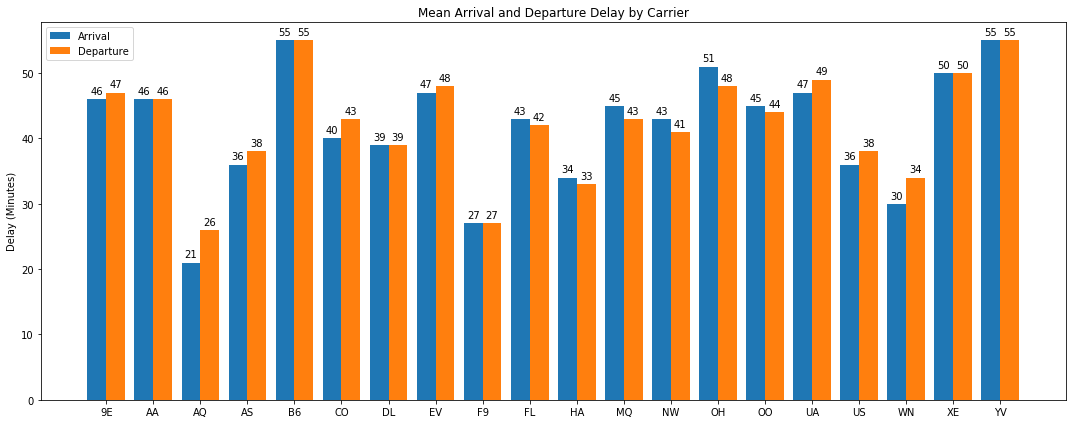

In [20]:
# Group the dataset by carrier and compute the mean for each variable
df_carrier_delay_perf = df_flight_delays[["UniqueCarrier", "ArrDelay", "DepDelay"]]
delay_means = df_carrier_delay_perf.groupby("UniqueCarrier").mean()

# Series to plot: mean arrival delay and mean departure delay by carrier
arrival_means = delay_means["ArrDelay"].astype("int64")
depart_means = delay_means["DepDelay"].astype("int64")
labels = delay_means.index

title = "Mean Arrival and Departure Delay by Carrier"
ylabel = "Delay (Minutes)"

# Plot mean departure and arrival delays by carrier
util.bi_bar_plot(labels, arrival_means, depart_means, "Arrival", "Departure", ylabel, title, figsize=(15, 6))

The bar plot shows that the mean delays for the best performing carrier, are slightly less than a half of the delays for the worst performing carrier. This applies to both, departure and arrival delays and is a considerable difference. 

In conclusion, the data shows that in 2008, the carrier with the shortest mean delays was AQ and the carrier with the longest mean delays was YV. Carrier AQ had a mean departure delay of 26 minutes and a mean arrival delay of 21 minutes, whereas YV had more than twice these numbers, with both, mean departure and arrival delays of 55 minutes.

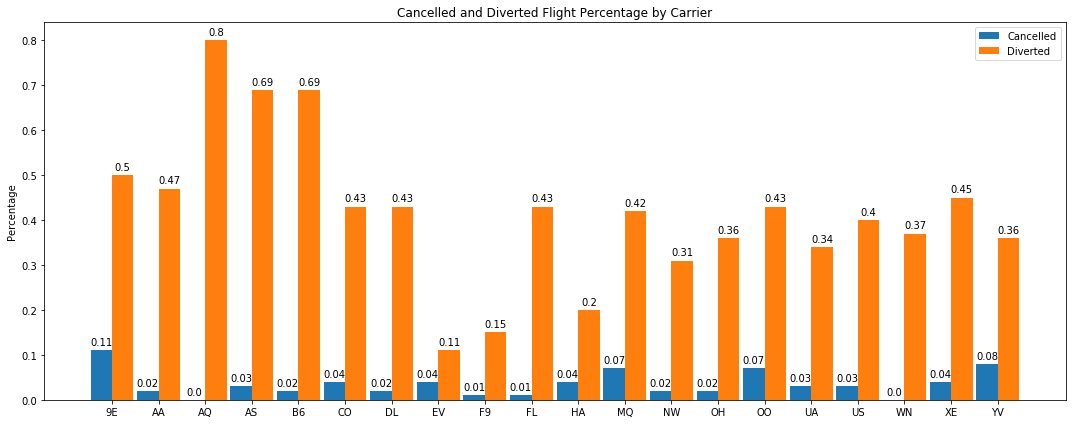

In [21]:
# Group the cancelled and diverted flights by carrier and compute their means
df_carrier_fail_perf = df_flight_delays[["UniqueCarrier", "Cancelled", "Diverted"]]
failed_ratios = df_carrier_fail_perf.groupby("UniqueCarrier").mean()

# Series to plot: total cancelled and diverted flights by carrier
cancel_percs = (failed_ratios["Cancelled"] * 100).round(2)
diverted_percs = (failed_ratios["Diverted"] * 100).round(2)
labels = failed_ratios.index

title = "Cancelled and Diverted Flight Percentage by Carrier"
ylabel = "Percentage"

# Plot percentage of cancelled and diverted flights by carrier
util.bi_bar_plot(labels, cancel_percs, diverted_percs, "Cancelled", "Diverted", ylabel, title, bar_width=0.46, figsize=(15, 6))

Regarding cancelled and diverted flights, we can see from the bar plot that in general, the percentage of cancelled and diverged flights is pretty low for all carriers (all less than 1%). We can also notice that results vary much more between carriers when compared to mean delays. 

The carrier with the highest percentage of diverted flights is AQ, with 0.8%. The carrier with the lowest percentage of such flights is WN, with a perfect record of 0%. Regarding cancelled flights, the carrier that got the highest percentage is 9E, but with just 0.11%. The carrier that got the lowest percentage was AQ, with 0% flights cancelled. Therefore, we come to the conclusion that all carriers had a good performance with respect to failed flights. Especially EV, which got a total of just 0.15% flights either cancelled or diverted.

##### 4.2 Delays and cancellations throughout the year

The second question is concerned with how delays, cancellations and diverted flights vary through the year:

2. Can we identify months of the year 2008 when delays were particularly long?

First let's visualize what the mean delays were every month.

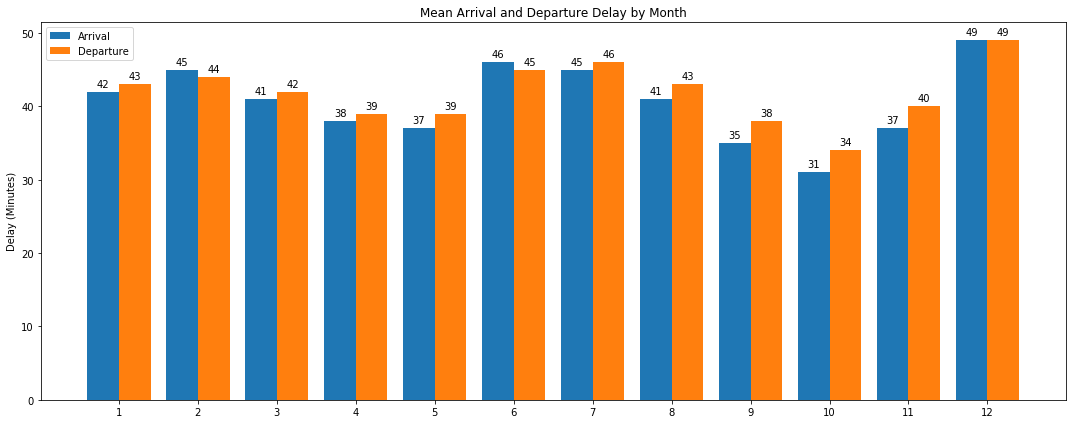

In [22]:
# Group delays by month and compute the mean for each variable
df_monthly_delays = df_flight_delays[["Month", "ArrDelay", "DepDelay"]]
delay_means_month = df_monthly_delays.groupby("Month").mean()

# Series to plot: mean arrival delay and mean departure delay by month
arrival_means_month = delay_means_month["ArrDelay"].astype("int64")
depart_means_month = delay_means_month["DepDelay"].astype("int64")
labels = delay_means_month.index

title = "Mean Arrival and Departure Delay by Month"
ylabel = "Delay (Minutes)"

# Plot mean departure and arrival delays by month
util.bi_bar_plot(labels, arrival_means_month, depart_means_month, "Arrival", "Departure", ylabel, title, figsize=(15, 6))

The maximum mean departure delay was 49 minutes and occurred in December. The minimum mean departure delay occurred in September and was 34 minutes. Then, the difference was 15 minutes, a rather modest variation considering that the standard deviation of the variable DepDelay was 53 (as calculated in 2.1). As we can see from the plot, mean arrival delays are rather homogeneous throughout the year, with a difference between minimum and maximum of 18 and a standard deviation of 57 in variable ArrDelay.

This suggests that the answer to the question is no, there are no months of the year when average departure or arrival delays are particularly long. As expected, December has slightly longer delays than the rest of the months.

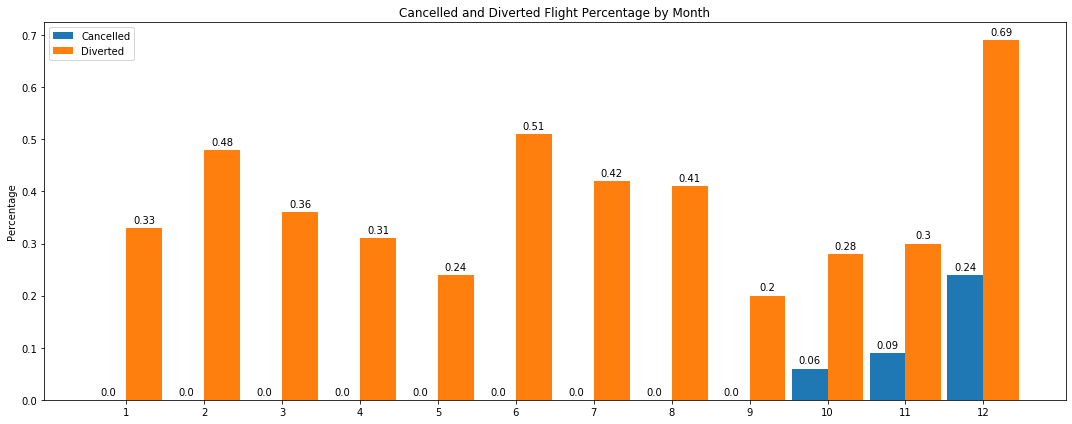

In [23]:
# Group the cancelled and diverted flights by month and compute their means
df_month_fail_perf = df_flight_delays[["Month", "Cancelled", "Diverted"]]
failed_ratios_month = df_month_fail_perf.groupby("Month").mean()

# Series to plot: total cancelled and diverted flights by month
cancel_percs_month = (failed_ratios_month["Cancelled"] * 100).round(2)
diverted_percs_month = (failed_ratios_month["Diverted"] * 100).round(2)
labels = failed_ratios_month.index

title = "Cancelled and Diverted Flight Percentage by Month"
ylabel = "Percentage"

# Plot percentage of cancelled and diverted flights by month
util.bi_bar_plot(labels, cancel_percs_month, diverted_percs_month, "Cancelled", "Diverted", ylabel, title, bar_width=0.46, figsize=(15, 6))

##### 4.3 Major delay causes

The dataset provides information about several factors that may delay flights. In the third question we will take a look at the significance of these factors.

3. What were the major causes of delays affecting domestic flights in the U.S. in 2008?

The correlation between the delay in the departure and arrival of a flight, with the delays introduced by each known factor, can be used to answer this question. This correlation provides a measure of how much of the departure and arrival delay is caused by each factor (carrier, weather, N.A.S, security events, late arrival of the aircraft).  

Text(0.5, 1, 'Correlation Among Delay Variables')

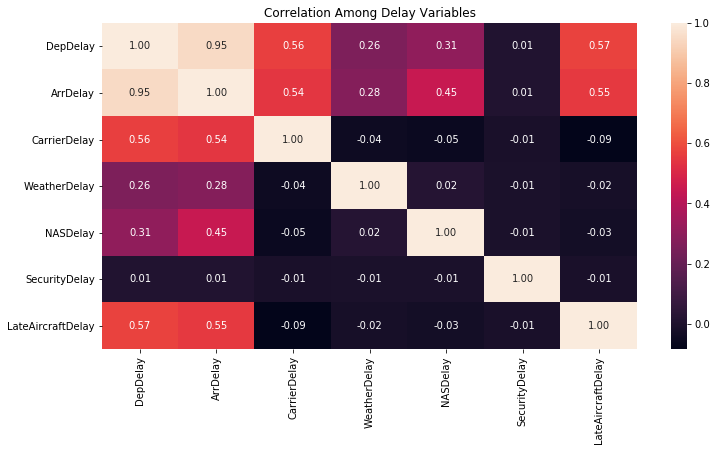

In [25]:
f, ax = plt.subplots(figsize=(12, 6))

# Compute the correlation among all delay variables
delay_correlation_mtx = df_success_flights[["DepDelay", "ArrDelay", "CarrierDelay", "WeatherDelay", 
                                            "NASDelay", "SecurityDelay", "LateAircraftDelay"]].corr()

# Plot a heatmap showing all these correlations 
sns.heatmap(delay_correlation_mtx, annot=True, fmt=".2f")

ax.set_title("Correlation Among Delay Variables")

The heatmap shows that departure delays were mostly caused by the aircraft arriving late at the origin airport and by problems related to the carrier. As expected, arrival delays are mostly associated with those same causes. This is because as also shown in the heatmap, most of the departure delay is reflected into the arrival delay (if the aircraft takes off late, most likely it will land equally late). 

##### 4.4 Estimation of flight delays

The fourth question asks about a model that predicts how delayed could a flight get, given some of its known attributes (e.g. carrier, origin airport, destination airport, date and time). Especifically, the question asks:

4. Can we build a model to estimate how much delay could be expected in a flight?

First, let's take a look at the correlation among variables that would be known before the flight takes place. These would be the variables we could use as independent variables to predict the potential delay of the flight.

Text(0.5, 1, 'Correlation Among Variables Known Prior to Flight and Arrival Delay')

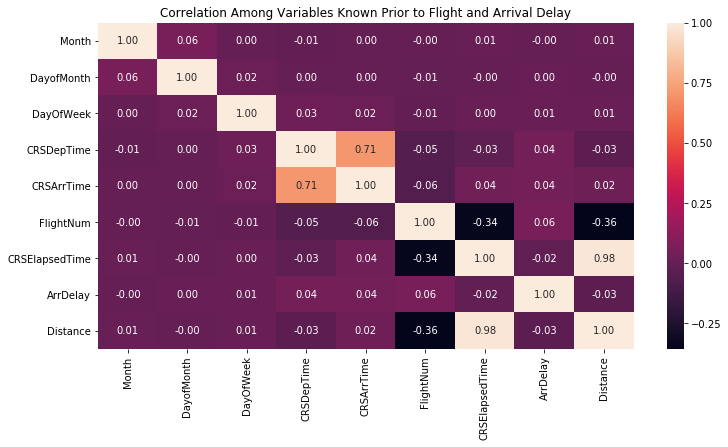

In [26]:
f, ax = plt.subplots(figsize=(12, 6))

# Compute the correlation among all independent variables and ArrDelay, the dependent variable
delay_correlation_mtx = df_success_flights[["Month", "DayofMonth", "DayOfWeek", "CRSDepTime", "CRSArrTime",
                                            "UniqueCarrier", "FlightNum", "TailNum", "CRSElapsedTime",
                                            "ArrDelay", "Origin", "Dest", "Distance"]].corr()

# Plot a heatmap showing all these correlations 
sns.heatmap(delay_correlation_mtx, annot=True, fmt=".2f")

ax.set_title("Correlation Among Variables Known Prior to Flight and Arrival Delay")

The heatmap of correlations shows two pairs of variables that are highly correlated: CRSDepTime (Scheduled Departure Time) with CRSArrTime (Scheduled Arrival Time) and Distance with CRSElapsedTime (Scheduled Elapsed Time). However these correlations are pretty obvious and are of no use in modeling delays. 

The correlations between ArrDelay and all other variables is very low. Hence, there is no direct relation between any of the independent variables and the arrival delay. However, a regression model still might discover more complex relations between these variables, so let's build a Linear Regression model to judge if that could work.

Firstly, we make some adjustments to the data. Namely, convert the variables Month, DayOfMonth and DayOfWeek to strings, so that they're treated as categorical variables by the regression algorithms. Then we transform all categorical variables into 0-1 encoding.

In [27]:
# Take a random sample of the dataset of successful flights, as it is too big to be processed in a PC
df_success_flights_sample = df_success_flights.sample(n=10000, axis=0)

# Only take variables that are unknown prior to the flight and the dependent variable, ArrDelay
df_success_flights_sub = df_success_flights_sample[["Month", "UniqueCarrier",
                                                    "FlightNum", "TailNum", "CRSElapsedTime",
                                                    "ArrDelay", "Origin", "Dest", "Distance"]]

# Note that Month, DayOfMonth and DayOfWeek are actually categorical. So, convert them to strings 
# to prevent the regression algorithm from interpreting them as ordered numbers
df_success_flights_sub = \
    df_success_flights_sub.astype({"Month": "str"})

# Encode all categorical variables using 0-1 encoding:
cat_vars = df_success_flights_sub.select_dtypes(include=["object"]).columns.values
df_processed = pd.get_dummies(df_success_flights_sub, prefix=cat_vars, columns=cat_vars, drop_first=True)

# The dependent variable is ArrDelay (arrival delay), the rest are independent variables
X = df_processed[np.setdiff1d(df_processed.columns.values, ["ArrDelay"])]
y = df_processed["ArrDelay"]

# Split the data in training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33)

Some experimenting shows that a Linear Regression model is not even remotely appropiate to model the ArrDelay with the data we have at our disposal. We conclude this after getting extremely negative results in all of our attempts to fit a Linear Regression model.

In [28]:
# Instantiate the model. Usually it's necessary to normalize (standarize) the data. It's the safe thing to do
lm_model = LinearRegression(normalize=True)

# Fit the model to the training data
lm_model.fit(X_train, y_train)

# Predict on the test data
y_test_preds = lm_model.predict(X_test)

# Score the model on the test data
# R-squared value to measure how well the predicted values compare to the actual test values
r2_test_lr = r2_score(y_test, y_test_preds)

print(f"R-Score with Linear Regression: {r2_test_lr}")

R-Score with Linear Regression: -1.7979140735683255e+29


Even fitting a Support Vector Regressor, a much more powerful technique, also resulted in a negative R-Score. Although the result improved considerably with respect to the Linear Regressor, the R-Score is still unnacceptably low.

In [29]:
# Feature scaling
sc_X = StandardScaler()
X_train = sc_X.fit_transform(X_train)
X_test = sc_X.transform(X_test)

sc_y = StandardScaler()
arr_y_train_scaled = sc_y.fit_transform(y_train.values.reshape(-1, 1))
y_train.iloc[:] = arr_y_train_scaled.squeeze()

# Instantiate the model. Use a Radial-Basis kernel, since looks like the data is non-linear
regressor = SVR(kernel="rbf", gamma="scale")

# Fit the model to the training data
regressor.fit(X_train, y_train)

# Predict on the test data
sc_y_test_preds = regressor.predict(X_test)
y_test_preds = sc_y.inverse_transform(sc_y_test_preds)

# Score the model on the test data
# R-squared value to measure how well the predicted values compare to the actual test values
r2_test_svr = r2_score(y_test, y_test_preds)

print(f"R-Score with Support Vector Regressor: {r2_test_svr}")

R-Score with Support Vector Regressor: -0.09029148703956236


##### 4.5 Conclusions

As a result of the Analysis and Modeling step, we conclude that by making use of descriptive statistics and plots, we can dig a lot of useful information about the data. We were able to answer the first three questions using these techniques and actually, there are many more interesting facts about the problem at hand that could be uncovered using traditional statistics.

Sadly we did not succeed in our attempt to build a regression model for flight delays based on this dataset. It could be that there are no deterministic relations among the independent variables and the dependent variable. There could also be many more variables that affect flight delays, but are not included in the dataset. 

Nevertheless, more advanced machine learning techniques and further analysis could prove otherwise.